In [1]:
import matplotlib.pylab as plt
import seaborn as sns

import numpy as np
import pandas as pd 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score ,confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [2]:
%matplotlib inline

In [3]:
df = pd .read_csv('../input/voice.csv')

In [4]:
Nsamples, Nfeatures = df.shape
print(f'Nsamples:{Nsamples}\nNfeatures: {Nfeatures}')

Nsamples:3168
Nfeatures: 21


In [5]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


<AxesSubplot:>

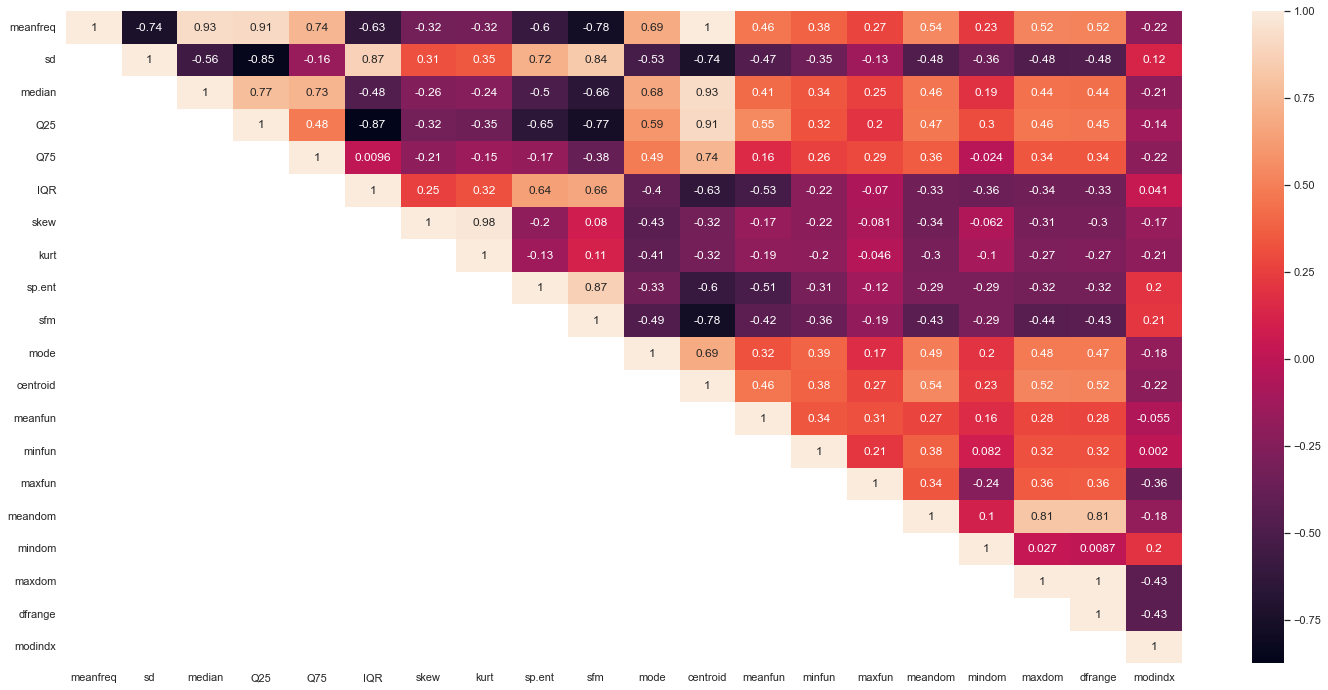

In [6]:
sns.set(style='whitegrid',color_codes=True)
cor_mat= df.corr(method='pearson')
mask = np.array(cor_mat)
mask[np.triu_indices_from(mask)] = False ## triangular inferior
fig=plt.gcf()
fig.set_size_inches(25,12)
sns.heatmap(data=cor_mat,mask=mask,annot=True,cbar=True)

## É possível observar que algumas das features são linearmente correlacionadas. Isso fornece índicios que é possível realizar uma redução de dimensionalidade para diminuir a redundância de features.

Temos como hipótese que as seguintes features são equivalentes:
- MeanFreq ~= Centroid
- dfrange ~= maxdom

## É interessante levantar algumas hipóteses sobre a distribuição dos dados.

In [7]:
def plot_male_female(feature):
    sns.catplot(data=df,y=feature, x='label',kind='box')
    fig=plt.gcf()
    fig.set_size_inches(10,10)

### Homens tendem a ter uma frequência média da voz mais baixa, i.e, grave.

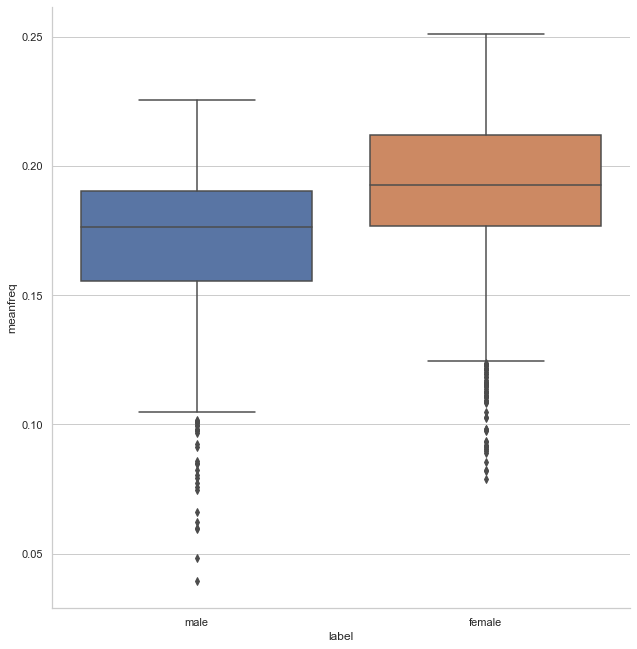

In [8]:
plot_male_female('meanfreq')

## Checando por valores de feature nulos 

In [9]:
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

## Enconding dos Labels e Balanceamento das classes. Como o número de amostras é igual nada muda.

In [10]:
print(df.label.value_counts())
dict = {'male':0,'female':1}
df.label.replace(dict,inplace = True)
df.head()

male      1584
female    1584
Name: label, dtype: int64


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,0
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,0
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,0
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,0
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,0


## Separação Amostras e Labels

In [11]:
X, y = df.loc[:, df.columns!='label'], df.loc[:, 'label']
X.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


# Classificação

In [12]:
cv = StratifiedKFold(n_splits=5,shuffle=True)
scores = {'acc' :make_scorer(accuracy_score), 
        'f1':make_scorer(f1_score)}

N_FEATURES_OPTIONS = list(range(1, X.shape[1]))
reducer_labels = ["PCA", "SVD"]
param_grid = [
    {
        "reduce_dim": [PCA(), TruncatedSVD()],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
    }
]


## LDA

In [13]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", LinearDiscriminantAnalysis()),
    ]
)
grid_LDA = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv)
grid_LDA.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        LinearDiscriminantAnalysis())]),
             param_grid=[{'reduce_dim': [PCA(n_components=12), TruncatedSVD()],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc',
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [14]:
results_LDA = pd.DataFrame(grid_LDA.cv_results_)
results_LDA[['params', 'param_reduce_dim__n_components','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",1,0.670763,0.683871
1,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",2,0.819756,0.812491
2,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",3,0.813127,0.807081
3,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",4,0.839641,0.823519
4,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",5,0.886354,0.879759
5,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",6,0.886358,0.880057
6,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",7,0.920769,0.918394
7,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",8,0.921086,0.918633
8,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",9,0.965910,0.965474
9,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",10,0.965594,0.965143


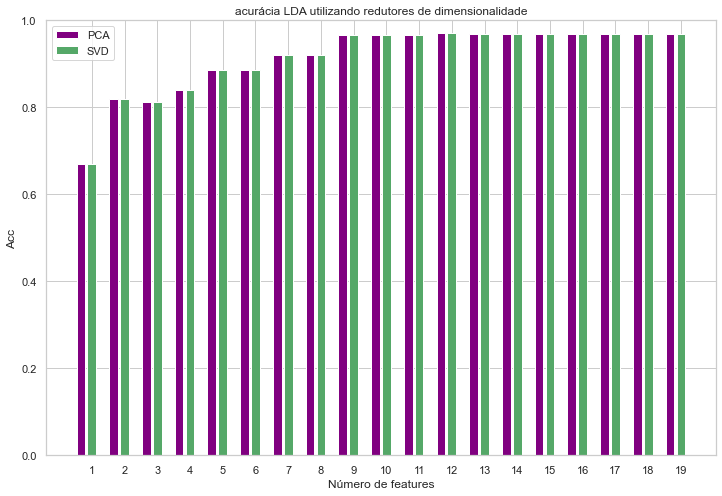

In [15]:
mean_scores = np.array(results_LDA["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
plt.figure(figsize=(12,8))
COLORS = ["Purple", "g", "r"]
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("acurácia LDA utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acc")
plt.ylim((0, 1))
plt.legend(loc="upper left")

plt.show()

## SVC

In [ ]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", SVC(kernel='linear', C=10, gamma='scale')),
    ]
)

grid_SVC = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv)
grid_SVC.fit(X, y)


In [ ]:
results_SVC = pd.DataFrame(grid_SVC.cv_results_)
results_SVC[['params', 'param_reduce_dim__n_components','mean_test_acc','mean_test_f1']]

In [ ]:
mean_scores = np.array(results_SVC["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
plt.figure(figsize=(12,8))
COLORS = ["Purple", "g", "r"]
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("acurácia SVM utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acc")
plt.ylim((0, 1))
plt.legend(loc="upper left")

plt.show()

## Random Forest

In [43]:
pipe = Pipeline(
    [
        ("reduce_dim", "passthrough"),
        ("classify", RandomForestClassifier()),
    ]
)
grid_RandomForest = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv)
grid_RandomForest.fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('reduce_dim', 'passthrough'),
                                       ('classify', RandomForestClassifier())]),
             param_grid=[{'reduce_dim': [PCA(), TruncatedSVD(n_components=18)],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc',
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [44]:
results_RandomForest = pd.DataFrame(grid_RandomForest.cv_results_)
results_RandomForest[['params', 'param_reduce_dim__n_components','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(), 'reduce_dim__n_component...",1,0.549250,0.549617
1,"{'reduce_dim': PCA(), 'reduce_dim__n_component...",2,0.659411,0.652855
2,"{'reduce_dim': PCA(), 'reduce_dim__n_component...",3,0.730433,0.724232
3,"{'reduce_dim': PCA(), 'reduce_dim__n_component...",4,0.761049,0.755952
4,"{'reduce_dim': PCA(), 'reduce_dim__n_component...",5,0.822609,0.821034
5,"{'reduce_dim': PCA(), 'reduce_dim__n_component...",6,0.823563,0.819912
6,"{'reduce_dim': PCA(), 'reduce_dim__n_component...",7,0.830183,0.827063
7,"{'reduce_dim': PCA(), 'reduce_dim__n_component...",8,0.843124,0.840585
8,"{'reduce_dim': PCA(), 'reduce_dim__n_component...",9,0.932136,0.930763
9,"{'reduce_dim': PCA(), 'reduce_dim__n_component...",10,0.937504,0.936163


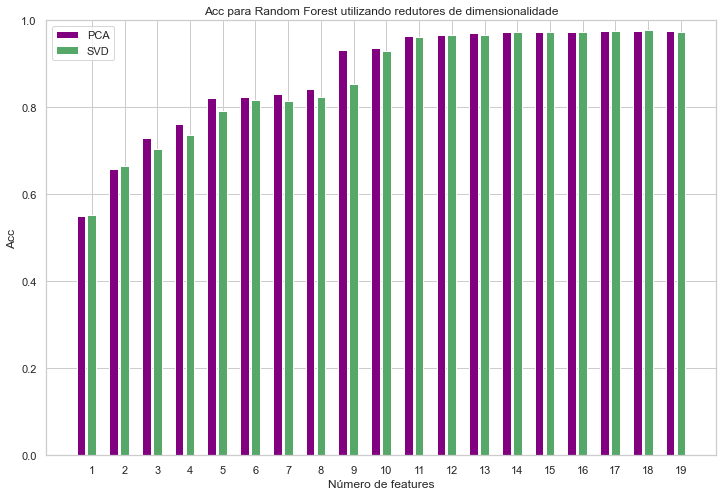

In [45]:
mean_scores = np.array(results_RandomForest["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
plt.figure(figsize=(12,8))
COLORS = ["Purple", "g", "r"]
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Acc para Random Forest utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acc")
plt.ylim((0, 1))
plt.legend(loc="upper left")

plt.show()

## NN

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
accs = []
for i in range(1,51):
    for j in range(1,51):
    print(f'iteration {i}.{j}...')
    ANN = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i,j)).fit(X_train,y_train)
    y_pred_ANN = ANN.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred_ANN))


## IDEIAS PARA APRIMORAMENTO

- Ver quais features são menos relevantes, i.e, tem mais correlação entre si. 
- Levantar hipóteses sobre as features
- Descrição das Features.
- SVM fine tuning
- Finalizar NN utilizando o mesmo CV invés do train_test_split que usei nos outros classificadores
- Comparar os resultados



Sinta-se livre para remodelar ou utilizar outros classificadores. Se precisar que eu ajude só avisar